<a href="https://colab.research.google.com/github/ealbenque/eurocode_3_steel/blob/main/tree/main/notebooks/2.0-ea-first_ok_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###dependencies



In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch import nn

from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

import seaborn as sns

scaler = MinMaxScaler()
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [7]:
import requests
from pathlib import Path

# Download helper functions
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/ealbenque/eurocode_3_steel/main/src/models/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


In [10]:
file_path = "https://github.com/ealbenque/eurocode_3_steel/raw/main/data/raw/EC3-section_and_stability.xls"

df = pd.read_excel(file_path,sheet_name='IPE_simple')
df = df[['section','Iy','Wy']]
df = df.drop(axis=0, index=0)
df

,section,Iy,Wy
1,IPE 80,801400,20030
2,IPE100,1710000,34200
3,IPE120,3178000,52960
4,IPE140,5412000,77320
5,IPE160,8693000,108700
6,IPE180,13170000,146300
7,IPE200,19430000,194300
8,IPE220,27720000,252000
9,IPE240,38920000,324300
10,IPE270,57900000,428900


###generation of training data

In [13]:
X = np.empty((0,2))
y = np.empty(0,dtype=int)
z = np.empty((0,),dtype=str)

crit = 200
L_list = np.linspace(2,15,num=100)
p_list = np.linspace(100,10000,num=100)
E_s = 210000000000 #Pa = N/m²
f_y = 235000000 #Pa = N/m²
section_check = 0

for L in L_list :
    i= 1
    for p in p_list:
        section_check = 0
        while (section_check ==0) & (i <= len(df)+1) :
            S_i = df.loc[i,'section']
            I_y_i = df.loc[i,'Iy']
            crit_i = 384 * E_s*I_y_i*10**(-12)/(5 *p*L**3)
            if crit_i>crit:
                section_check = 1
                X = np.append(X,[[L,p]],axis=0)
                y = np.append(y,i)
                z = np.append(z,[S_i],axis=0)
            else:
                i+=1

In [14]:
print(len(df))

17


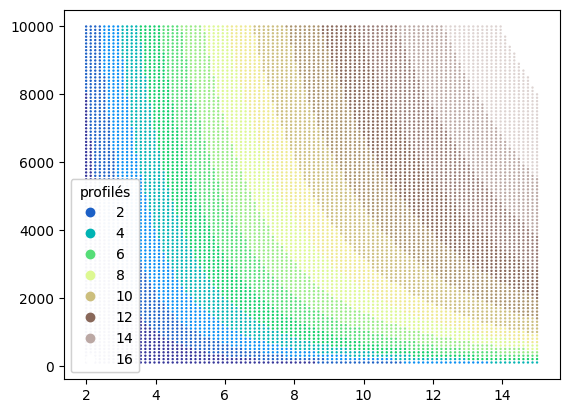

In [15]:
fig, ax = plt.subplots()
scatter = ax.scatter(X[:,0],X[:,1], c=y[:], cmap='terrain',s=0.5)

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="profilés")
ax.add_artist(legend1)

plt.show()

In [16]:
X = scaler.fit_transform(X)
print(X)

[[0.         0.        ]
 [0.         0.01010101]
 [0.         0.02020202]
 ...
 [1.         0.97979798]
 [1.         0.98989899]
 [1.         1.        ]]


###build model

In [17]:
# Set the hyperparameters
NUM_CLASSES = 17
NUM_FEATURES = 2
RANDOM_SEED = 42

In [18]:
print(y[:500])
print(X)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 3 3 3 3 3 3 3 3 

tensor([[0.0000, 0.0000],
        [0.0000, 0.0101],
        [0.0000, 0.0202],
        [0.0000, 0.0303],
        [0.0000, 0.0404]]) tensor([1, 1, 1, 1, 1])


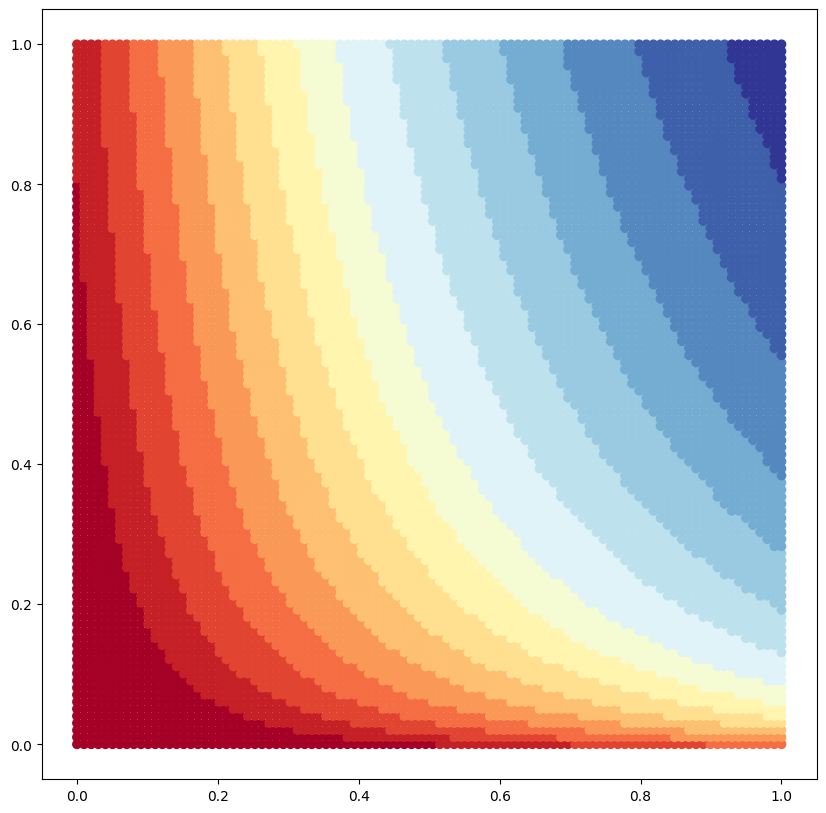

In [19]:
# 2. Turn data into tensors
X_ = torch.from_numpy(X).type(torch.float)
y_ = torch.from_numpy(y).type(torch.LongTensor)
print(X_[:5], y_[:5])

# 3. Split into train and test sets
X__train, X__test, y__train, y__test = train_test_split(X_,
    y_,
    test_size=0.2,
    random_state=RANDOM_SEED
)

# 4. Plot data
plt.figure(figsize=(10, 10))
plt.scatter(X_[:, 0], X_[:, 1], c=y_, cmap=plt.cm.RdYlBu);

In [20]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

In [22]:
# Build model
class Model(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=128):
        """Initializes all required hyperparameters for a multi-class classification model.

        Args:
            input_features (int): Number of input features to the model.
            out_features (int): Number of output features of the model
              (how many classes there are).
            hidden_units (int): Number of hidden units between layers, default 8.
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features),
        )

    def forward(self, x):
        return self.linear_layer_stack(x)

# Create an instance of Model and send it to the target device
model_4 = Model(input_features=NUM_FEATURES,
                    output_features=NUM_CLASSES,
                    hidden_units=128).to(device)
model_4

Model(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=17, bias=True)
  )
)

In [23]:
# Create loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(),
                            lr=0.01)

In [24]:
# How many elements in a single prediction sample?
model_4(X__train.to(device))[0].shape, NUM_CLASSES

(torch.Size([17]), 17)

In [25]:
# Make prediction logits with model
y_logits = model_4(X__test.to(device))

# Perform softmax calculation on logits across dimension 1 to get prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[ 7.7494e-02,  4.8811e-03,  1.8424e-01, -2.9980e-02,  1.8687e-02,
         -5.3966e-02, -1.5907e-01, -2.4456e-01, -1.5085e-02, -2.5955e-02,
         -3.0052e-02, -1.6715e-02, -1.7178e-01, -2.5087e-02,  2.6884e-01,
         -7.2918e-02, -6.4983e-02],
        [ 3.7609e-02, -2.6662e-02,  1.6446e-01, -2.0306e-02,  2.1140e-02,
         -4.2731e-02, -1.8309e-01, -2.6889e-01, -2.1596e-02, -2.3301e-02,
         -2.8352e-02, -2.5840e-02, -1.5958e-01, -2.6496e-02,  2.9544e-01,
         -6.2388e-02, -8.1720e-02],
        [ 8.3417e-02, -2.2979e-02,  1.4669e-01, -4.6693e-02,  2.8034e-02,
         -6.7227e-02, -1.3258e-01, -2.1899e-01,  7.6860e-03, -2.8097e-02,
         -6.1490e-02,  8.0895e-03, -1.2402e-01, -2.9882e-02,  2.4678e-01,
         -9.3915e-02, -7.9821e-02],
        [ 7.6361e-02, -1.0182e-04,  1.6928e-01, -3.3323e-02,  1.9574e-02,
         -6.0164e-02, -1.4791e-01, -2.3439e-01, -9.8230e-03, -2.8236e-02,
         -4.2468e-02, -1.0150e-02, -1.5733e-01, -2.6018e-02,  2.6203e-01,
    

In [26]:
# Sum the first sample output of the softmax activation function
torch.sum(y_pred_probs[0])

tensor(1., device='cuda:0', grad_fn=<SumBackward0>)

In [27]:
# Which class does the model think is *most* likely at the index 0 sample?
print(y_pred_probs[0])
print(torch.argmax(y_pred_probs[0]))

tensor([0.0644, 0.0599, 0.0717, 0.0579, 0.0608, 0.0565, 0.0509, 0.0467, 0.0588,
        0.0581, 0.0579, 0.0587, 0.0502, 0.0582, 0.0780, 0.0554, 0.0559],
       device='cuda:0', grad_fn=<SelectBackward0>)
tensor(14, device='cuda:0')


In [29]:
# Fit the model
torch.manual_seed(42)

# Set number of epochs
epochs = 100000

# Put data to target device
X__train, y__train = X__train.to(device), y__train.to(device)
X__test, y__test = X__test.to(device), y__test.to(device)

for epoch in range(epochs):
    ### Training
    model_4.train()

    # 1. Forward pass
    y_logits = model_4(X__train) # model outputs raw logits
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # go from logits -> prediction probabilities -> prediction labels
    # print(y_logits)
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y__train)
    acc = accuracy_fn(y_true=y__train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_4.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_4(X__test)
      test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
      # 2. Calculate test loss and accuracy
      test_loss = loss_fn(test_logits, y__test)
      test_acc = accuracy_fn(y_true=y__test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
Epoch: 50000 | Loss: 0.20214, Acc: 96.86% | Test Loss: 0.20524, Test Acc: 96.75%
Epoch: 50010 | Loss: 0.20211, Acc: 96.86% | Test Loss: 0.20521, Test Acc: 96.75%
Epoch: 50020 | Loss: 0.20207, Acc: 96.85% | Test Loss: 0.20518, Test Acc: 96.75%
Epoch: 50030 | Loss: 0.20204, Acc: 96.84% | Test Loss: 0.20515, Test Acc: 96.75%
Epoch: 50040 | Loss: 0.20201, Acc: 96.85% | Test Loss: 0.20511, Test Acc: 96.75%
Epoch: 50050 | Loss: 0.20198, Acc: 96.85% | Test Loss: 0.20508, Test Acc: 96.75%
Epoch: 50060 | Loss: 0.20195, Acc: 96.84% | Test Loss: 0.20505, Test Acc: 96.75%
Epoch: 50070 | Loss: 0.20191, Acc: 96.84% | Test Loss: 0.20502, Test Acc: 96.75%
Epoch: 50080 | Loss: 0.20188, Acc: 96.84% | Test Loss: 0.20499, Test Acc: 96.80%
Epoch: 50090 | Loss: 0.20185, Acc: 96.84% | Test Loss: 0.20496, Test Acc: 96.80%
Epoch: 50100 | Loss: 0.20182, Acc: 96.84% | Test Loss: 0.20492, Test Acc: 96.80%
Epoch: 50110 | Loss: 0.20179, A

In [30]:
# Make predictions
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X__test)

# View the first 10 predictions
y_logits[:10]

tensor([[ -42.1750, -364.8438, -254.2239, -191.2146, -133.2940,  -68.0508,
          -12.7986,   39.9606,   89.4418,  124.9207,  150.5307,  158.3145,
          147.2001,  120.5873,   88.8455,   53.7718,   78.2193],
        [ -43.7372, -322.4115, -215.5263, -156.0979, -101.7608,  -41.2268,
            9.2266,   54.8288,   97.3125,  126.3154,  142.6897,  140.0678,
          119.5623,   84.7442,   46.6365,    3.4815,   41.5689],
        [ -41.0677,  202.5902,  226.9194,  239.0238,  237.7920,  228.1725,
          199.3473,  172.4142,  132.9522,   73.3189,   -6.3425,  -84.0422,
         -180.5717, -280.6691, -360.1499, -427.6237, -329.8963],
        [ -42.2674, -169.4249,  -91.2007,  -45.8689,   -5.0624,   38.1679,
           70.6444,   96.0829,  111.3052,  113.0587,  100.4329,   73.9153,
           30.1493,  -23.9601,  -73.3377, -120.0554,  -72.3358],
        [ -39.3858,   -5.3843,   41.5323,   69.4144,   92.9982,  114.9871,
          126.3350,  127.0569,  116.2779,   92.0963,   52.1069,  

In [31]:
# Turn predicted logits in prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)

# Turn prediction probabilities into prediction labels
y_preds = y_pred_probs.argmax(dim=1)

# Compare first 10 model preds and test labels
print(f"Predictions: {y_preds[:10]}\nLabels: {y__test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_true=y__test, y_pred=y_preds)}%")

Predictions: tensor([11, 10,  3,  9,  7, 10,  3,  3, 12,  2], device='cuda:0')
Labels: tensor([11, 10,  3,  9,  7, 10,  3,  3, 12,  1], device='cuda:0')
Test accuracy: 97.75%


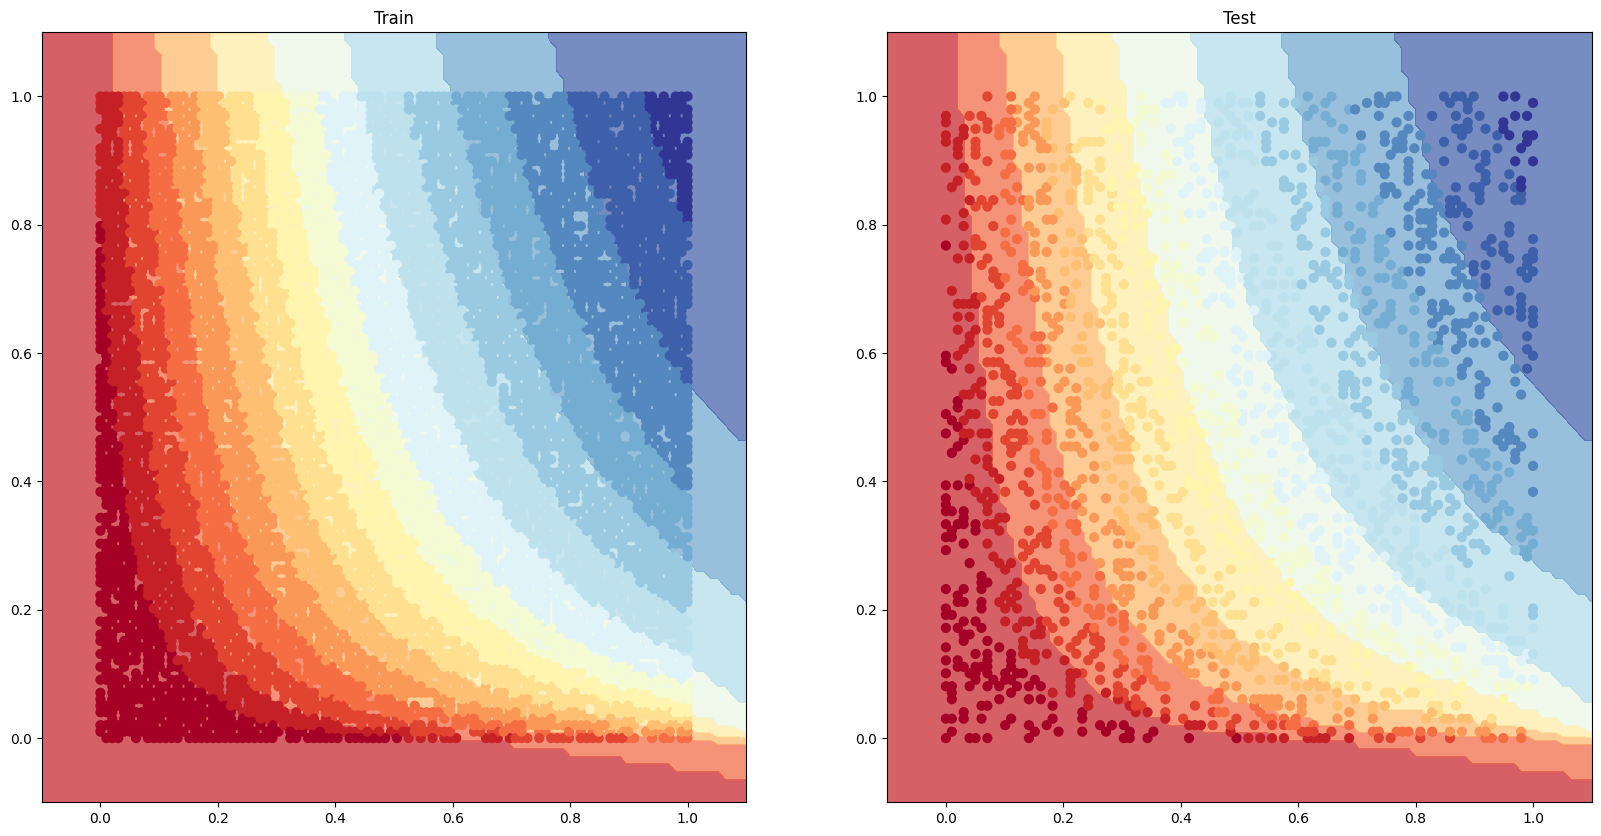

In [35]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X__train, y__train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X__test, y__test)